# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe_xang.csv"

In [3]:
var_file_name = 'arimax_gia_nang_xuat.joblib'
varma_file_name = 'arimax_gia_lua_xang.joblib'


In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,RON 95-III
date,,
2018-08-22,33700.0,21.17
2018-08-23,33400.0,21.17
2018-08-24,33100.0,21.17
2018-08-25,33300.0,21.17
2018-08-26,33300.0,21.17


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2105 entries, 2018-08-22 to 2024-05-29
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       2105 non-null   float64
 1   RON 95-III  2105 non-null   float64
dtypes: float64(2)
memory usage: 49.3+ KB


<Axes: >

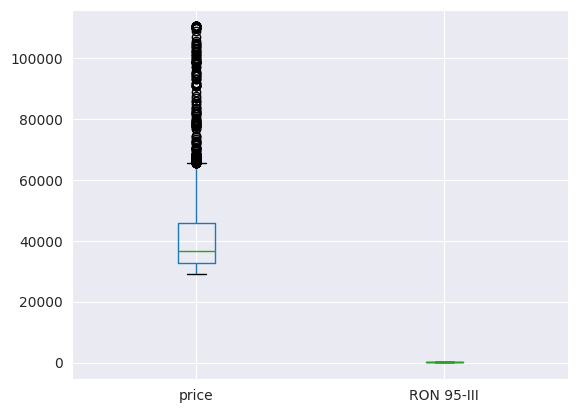

In [8]:
df.boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 247


<Axes: >

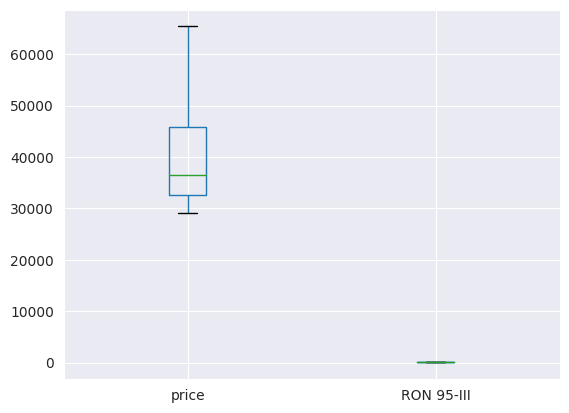

In [10]:
df.boxplot()

In [11]:
df = df.dropna()

In [12]:
df_corr = df.copy()

In [13]:
# Find the pearson correlations matrix
corr = df_corr.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.547534
RON 95-III,0.547534,1.000000


In [14]:
df = df_corr

In [15]:
fillter_feature = ['price', 'RON 95-III']
df = df[fillter_feature]

In [16]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.547534
RON 95-III,0.547534,1.000000


<Axes: xlabel='date'>

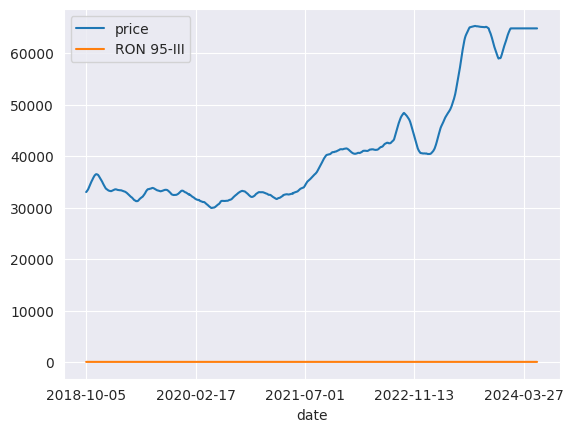

In [17]:
df.price = df.price.rolling(45).mean()
df = df.dropna()
df.plot()

In [18]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1648, 2)
(413, 2)


In [19]:
from google.colab import files


## Kiểm tra stationary

In [20]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [21]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.3457
 No. Lags Chosen       = 17
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.9188. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5417
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.5128. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [22]:
# df_differenced = np.log(df_train)
# df_differenced = df_differenced.dropna()
# df_differenced = df_differenced[1:]

In [23]:
df_differenced = df_train.diff().dropna()

In [24]:
df_differenced

,price,RON 95-III
date,,
2018-10-06,37.777778,0.57
2018-10-07,44.444444,0.00
2018-10-08,51.111111,0.00
2018-10-09,57.777778,0.00
2018-10-10,62.222222,0.00
...,...,...
2023-04-05,82.222222,0.00
2023-04-06,95.555556,0.00
2023-04-07,80.000000,0.00


In [25]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.129
 No. Lags Chosen       = 16
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6257
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




<Axes: xlabel='date'>

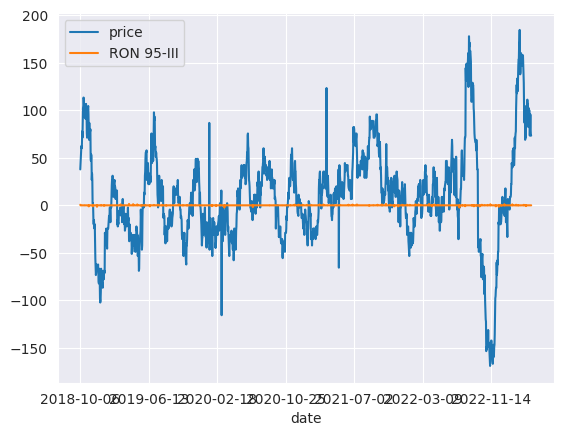

In [26]:
df_differenced.plot()

## Train model

### Đánh giá mô hình VAR

In [27]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [28]:
columns_train = fillter_feature

In [29]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.4 MB/s eta 0:00:00


In [30]:
from pmdarima import auto_arima

In [31]:
arimax = auto_arima(df_differenced.price, exogenous = df_differenced['RON 95-III'],
           start_p=3,
           start_q=3,
           max_p=7,
           max_q=7,
            seasonal=False,
          trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12994.733, Time=12.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13104.685, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13003.291, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12991.260, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13102.689, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12992.912, Time=0.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12992.887, Time=1.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12992.702, Time=6.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12989.268, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12990.921, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12990.896, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13001.298, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12990.709, Time=1.78 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 27.296 seconds


In [32]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [33]:
# Forecast
n_periods = len(df_test)
fitted, confint = arimax.predict(n_periods=n_periods,
                                  exogenous=[ 'area'],
                                  return_conf_int=True)


In [34]:
np.square(fitted)

2023-04-10    5486.385481
2023-04-11    5486.385481
2023-04-12    5486.385481
2023-04-13    5486.385481
2023-04-14    5486.385481
                 ...     
2024-05-22    5486.385481
2024-05-23    5486.385481
2024-05-24    5486.385481
2024-05-25    5486.385481
2024-05-26    5486.385481
Freq: D, Length: 413, dtype: float64

In [35]:
df_test.index

Index(['2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14',
       '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19',
       ...
       '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24',
       '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29'],
      dtype='object', name='date', length=413)

In [36]:
fc_series = pd.DataFrame({'price': fitted.values}, index = df_test.index)

In [37]:
fc_series

,price
date,
2023-04-10,74.070139
2023-04-11,74.070139
2023-04-12,74.070139
2023-04-13,74.070139
2023-04-14,74.070139
...,...
2024-05-25,74.070139
2024-05-26,74.070139
2024-05-27,74.070139


<Axes: xlabel='date'>

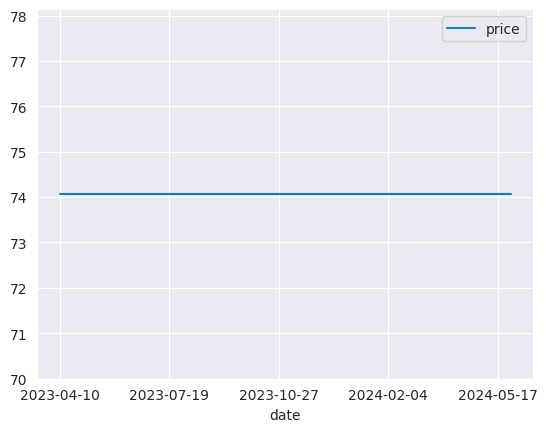

In [38]:
fc_series.plot()

In [39]:
fc_series.price = df_test.price.iloc[0] + fc_series.price.cumsum()

<Axes: xlabel='date'>

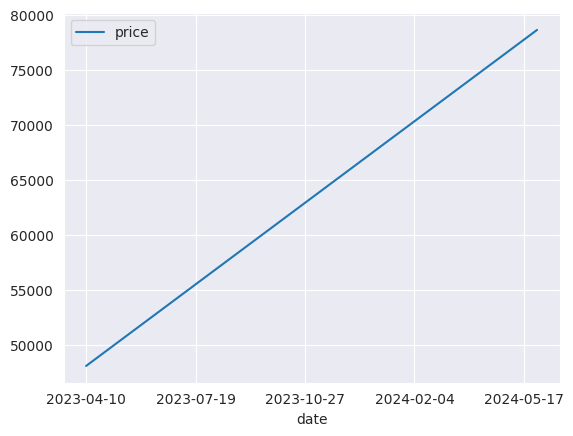

In [40]:
fc_series.plot()

Đánh giá mô hình

In [41]:
accuracy_prod = forecast_accuracy(fc_series['price'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

mape :  9.7288
rmse :  7074.8866


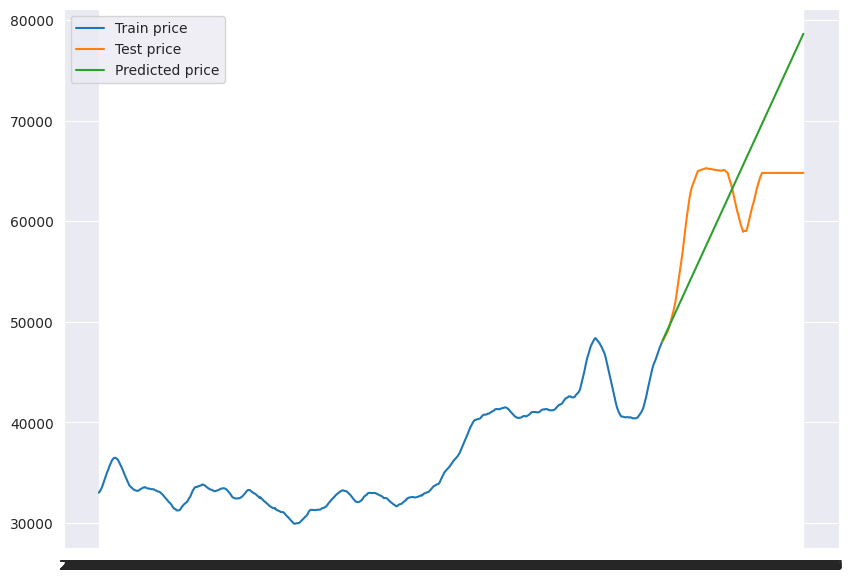

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(fc_series[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [45]:
import joblib
from google.colab import drive

file_name = "arimax_gia_cafe_xang.joblib"
drive.mount('/content/drive')

joblib.dump(arimax, '/content/drive/MyDrive/model/' + file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/model/arimax_gia_cafe_xang.joblib']